# Regression task

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.


## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import optuna

In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
#Set random seed to reproduce same results
seed = 1997
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

#from pytorch_lightning import Trainer, seed_everything
#seed_everything(seed, workers=True) 
#seed_everything(42, workers=True)
# sets seeds for numpy, torch and python.random.
#By setting workers=True in seed_everything(), Lightning derives unique seeds across all dataloader workers and processes for torch,
#numpy and stdlib random number generators. When turned on, it ensures that e.g. data augmentations are not repeated across workers.#


The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

How to load the data:

# Data Regression 

In [11]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-06-21 15:03:09--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.2’

train_data.csv.2    100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-06-21 15:03:09 (56.7 MB/s) - ‘regression_dataset/train_data.csv.2’ saved [3776/3776]

--2022-06-21 15:03:10--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv.2’

test_dat

In [12]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [13]:
class CsvDataset(Dataset):

  def __init__(self, csv_file: str, transform=None):
    self.transform = transform
    self.data = csv_file

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # sample: ('index', 'label) --> sample = (csv_file index elem, csv_file column element)
    sample = (self.data.iloc[idx][0], self.data.iloc[idx][1])
    if self.transform:
        sample = self.transform(sample)
    return sample

In [14]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

print(len(train_df))
print(len(test_df))

100
100


In [15]:
train_split, val_split = train_test_split(train_df,test_size=0.3, shuffle= True)
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print(len(train_split))
print(len(val_split))

70
30


From:https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.The Dataset is responsible for accessing and processing single instances of data.The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

In [16]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset(train_split, transform=composed_transform)
val_dataset = CsvDataset(val_split, transform=composed_transform)
test_dataset= CsvDataset(test_df, transform=composed_transform)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=20, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)


In [18]:
#Plot data

SAMPLE AT INDEX 9
INPUT: -3.44016058929888
LABEL: 2.8657826429373463


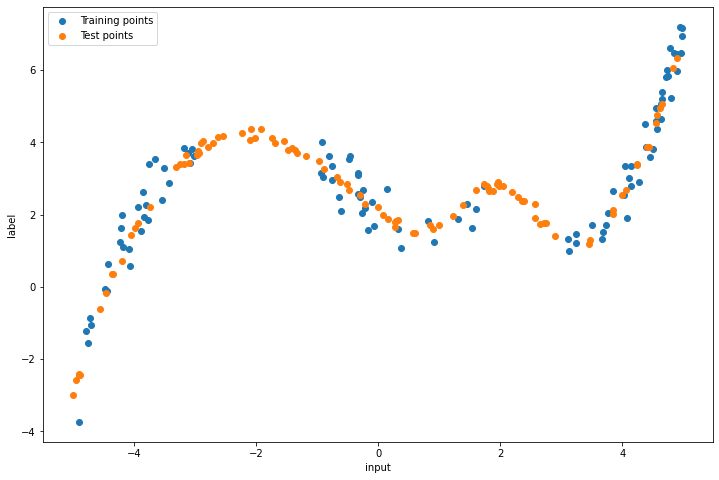

In [19]:
sample_index = 9
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

# Model class + train func

In [27]:
from matplotlib.cbook import dedent
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, drop=0.2):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()

        print('Network initialized')
        # network definition with just its architecture  
        
    def forward(self, x, additional_out = -1):
        x1 = self.act(self.fc1(x))
        x2 = self.act(self.fc2(x1))
        out = self.out( x2 )
        #x = [x1, x2]
        
        #if additional_out != -1:
        #    return out, x[additional_out]
        return out
        # in order of propagate information inside the network it's necessary the forward step that makes the layers 
        # acting on the samples
    
    def train_step(self, train_data, optimizer, loss_fn, device):
        """
        Train the @self on dataloader @train_data with a given loss function and an optimizer.
        The function gives back the mean of the loss over different batches and its 
        standard deviation
        """
        # enabling training 
        self.train()
        # training step

        train_loss = []
        for sample_batched in train_data:
            # let's split data into values and lables and move them to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
        return train_loss
    
    def eval_step(self, val_data, loss_fn, device):
        """
        Validate/testing  @self on dataloader @val_data given a loss function and the chosen optimizer.
        The function returns the mean of validation loss over batches and its std deviation
        """
        val_loss = []
        # Evaluation mode (e.g. disable dropout)
        self.eval() 

        # Disable gradient tracking
        with torch.no_grad(): 
            for sample_batched in val_data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        return val_loss
    
    def fit(self, device, train_data, val_data, num_epochs, optimizer, loss_fn):
        """
        Training procedure for @self on the data @dataset
        Arguments of the function:
            self (Net)          : Neural network model
            train_data          : Dataloader of train set
            val_data            : Dataloader of validation set
            optimizer           : optimizer for gradient descent
            loss_fn             : loss function 
            dic_params (dict)   : Contains all the parameters
        """

        train_loss_seq = []
        val_loss_seq = []

        for epoch_num in range(num_epochs):
            # training step 
            train_loss = self.train_step(train_data, optimizer, loss_fn,  device)
            train_loss = np.mean(train_loss)
            # train average loss is saved in order to get at the end a sequance of averages over batches
            train_loss_seq.append(train_loss)
            # validaton step 
            val_loss = self.eval_step(val_data, loss_fn,  device)
            val_loss = np.mean(val_loss)
            val_loss_seq.append(val_loss)
            
        return train_loss_seq, val_loss_seq
                
                    
    def test(self, test_loader, device, loss_fn):
        """
        Test @self on dataloader @test_loader and returns accuracy
        """
        accuracy = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(test_loader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1][0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                # Save val loss for this batch
                accuracy.append( loss_batch.mean() )
        return np.array(accuracy).mean()
    
    # the result network can be saved in memory and it can be loaded back into the pytorch structure 

    def save_net(self, path):
        torch.save(self.state_dict(), path)
        
    def load_net(self, path):
        self.load_state_dict(torch.load(path))

# Exercise: basic regression

In [18]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 8
Nh2 = 8
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

#Epochs
epochs = 400

Network initialized


In [19]:
#self, device, train_data, val_data, num_epochs, optimizer, loss_fn

train_loss, val_loss  = net.fit(device, train_dataloader, val_dataloader,  epochs, optimizer, loss_fn)

In [20]:
print(len(train_loss))
print(len(val_loss))

400
400


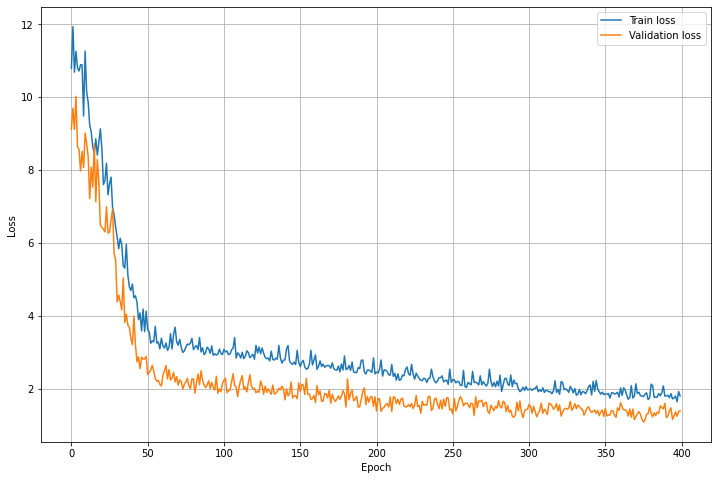

In [21]:
# Plot losses
plt.figure(figsize=(12,8))
#plt.semilogy
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [22]:
x_vec = torch.linspace(-5.5,5.5,1000).to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
#beta_true = [-1.45, 1.12, 2.3]
#true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


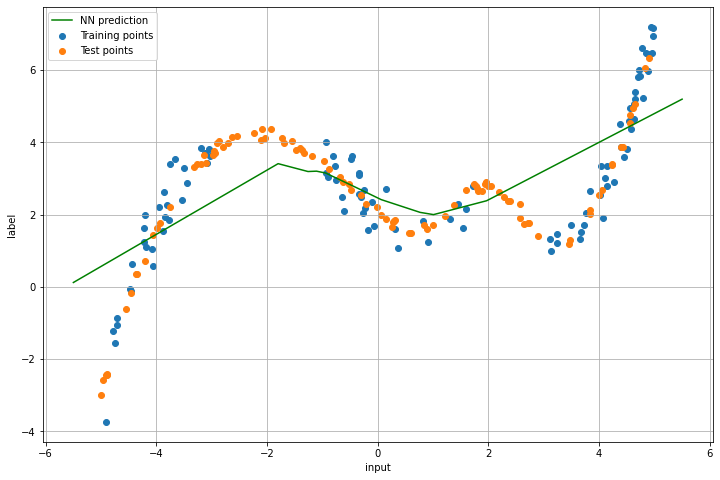

In [23]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.plot(x_vec, y_vec, label='NN prediction', color='green')
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()

# Pytorch lighting module

In [28]:
! pip install pytorch-lightning

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.net = nn.Sequential(
                       nn.Linear(in_features=Ni, out_features=Nh1), 
                       nn.Linear(in_features=Nh1, out_features=Nh2),
                       nn.Linear(in_features=Nh2, out_features=No),
                       nn.ReLU())
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.mse_loss(out, label_batch)
        self.train_loss.append(loss.item()) #loss.item() instead of loss ...
        self.log("train_loss ", loss)
        return loss #bug of lightning need to return loss here

    def validation_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.mse_loss(out, label_batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_loss.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-2)
        return optimizer



In [66]:
###Se volessi runnare il modello con pytorch lightning 
#batch_size = 100
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
#test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)
##
#from pytorch_lightning.callbacks import ModelCheckpoint
#checkpoint_callback = ModelCheckpoint(dirpath="tiprego", monitor="val_loss")
##
#trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None, max_epochs=10, val_check_interval=1,
#                     log_every_n_steps=10,callbacks=[checkpoint_callback])
#litnet = LitNet(1, 128, 64, 1)
#trainer.fit(litnet, train_dataloader, val_dataloader)
##
##
##
##checkpoint_callback.best_model_path
#

In [ ]:
# Plot losses
#plt.figure(figsize=(12,8))
#plt.plot(litnet.train_loss, label='Train loss')
#plt.plot(litnet.val_loss, label='Validation loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.grid()
#plt.legend()
#plt.show()
#

# Exercise: Explore advanced optimizers and regularization methods (both tasks). ----- in hyperparameter tuning

In [35]:
# Before we used: 
# Nh1 = 128
# Nh2 = 256

import optuna
from optuna.integration import PyTorchLightningPruningCallback

def objective(trial):

    # We optimize the number of hidden units in each layer.
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 64, 256, 64,log=False) for i in range(2)
    ]

    model = LitNet(Ni, output_dims[0], output_dims[1], No)

    trainer = pl.Trainer(gpus=0, max_epochs=20, val_check_interval=1, log_every_n_steps=1)
    hyperparameters = dict(output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics["val_loss"].item()

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=3, timeout=300)

[I 2022-06-21 09:24:53,034] A new study created in memory with name: myfirstoptimizationstudy
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 33.5 K
------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


Network initialized


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 09:25:04,175] Trial 0 finished with value: 2.9972944259643555 and parameters: {'n_units_l0': 128, 'n_units_l1': 256}. Best is trial 0 with value: 2.9972944259643555.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 16.9 K
------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


Network initialized


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 09:25:12,975] Trial 1 finished with value: 2.616342067718506 and parameters: {'n_units_l0': 128, 'n_units_l1': 128}. Best is trial 1 with value: 2.616342067718506.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 50.0 K
------------------------------------
50.0 K    Trainable params
0         Non-trainable params
50.0 K    Total params
0.200     Total estimated model params size (MB)


Network initialized


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-21 09:25:26,545] Trial 2 finished with value: 10.834415435791016 and parameters: {'n_units_l0': 192, 'n_units_l1': 256}. Best is trial 1 with value: 2.616342067718506.


In [37]:
 print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 3
Best trial:
  Value: 2.616342067718506
  Params: 
    n_units_l0: 128
    n_units_l1: 128


# Kfold + cross validation insieme 

In [ ]:
#Non chiedetemi come ma fa kfold e hypertuning insieme!

In [32]:
from sklearn.model_selection import KFold


In [81]:
def objective2(trial):


  
    #Define the hyperparameters 
   
    #Number of hidden units in the middle layers.
    units_1 = trial.suggest_int("units_1", 64, 256, 64)
    units_2 = trial.suggest_int("units_2", 16, 128, 16)  

    #Define the model
    net = LitNet(1,units_1,units_2,1).to(device)

    #Optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_norm = trial.suggest_loguniform('weigth_norm',1e-4, 1e0) #Regularization    
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=lr,weight_decay=weight_norm)

    #Define the cross validation module 
    fold = KFold(n_splits=3, shuffle=True, random_state=seed)
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
        train_data = torch.utils.data.Subset(train_dataset, train_idx)
        valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=10,
            shuffle=True,
        )
        val_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=10,
            shuffle=False, #false secondo gli warning
        )
    
        print('------- FOLD',fold_idx,'-------')

        #Fit module
        early_stop = pl.callbacks.EarlyStopping('val_loss', patience=50)
        trainer = pl.Trainer(gpus=0, max_epochs=5, val_check_interval=1, callbacks=early_stop,
                             log_every_n_steps=1, enable_model_summary = False, 
                            )
    
        hyperparameters = dict(
                          units_1 = units_1,
                          units_2 = units_2,
                          optimizer=optimizer_name,
                          lr = lr,
                          weight_norm= weight_norm)
                            
        trainer.logger.log_hyperparams(hyperparameters)
        trainer.fit(net, train_loader, val_loader)
    print('------------------------------------------')

    return trainer.callback_metrics["val_loss"].item()



In [82]:
pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective2, n_trials=2, timeout=300)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


Network initialized
------- FOLD 0 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


------- FOLD 1 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


------- FOLD 2 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


------------------------------------------
Network initialized
------- FOLD 0 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


------- FOLD 1 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


------- FOLD 2 -------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

------------------------------------------


In [84]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 2
Best trial:
  Value: 5.569833278656006
  Params: 
    units_1: 64
    units_2: 16
    optimizer: SGD
    lr: 0.0001557560386446708
    weigth_norm: 0.23759764332618094


In [58]:
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    units_1: 128
    units_2: 32
    optimizer: Adam
    lr: 2.460099106674436e-05


# Best model training + plot

In [85]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 64
Nh2 = 16
No = 1
best_net = Net(Ni, Nh1, Nh2, No)
best_net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.23759764332618094)

#Epochs
epochs = 400

Network initialized


NameError: ignored

In [ ]:
#self, device, train_data, val_data, num_epochs, optimizer, loss_fn

train_loss, val_loss  = best_net.fit(device, train_dataloader, val_dataloader,  epochs, optimizer, loss_fn)

In [ ]:
 #fold = KFold(n_splits=3, shuffle=True, random_state=seed)
 #   for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
 #       train_data = torch.utils.data.Subset(train_dataset, train_idx)
 #       valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

 #       train_loader = torch.utils.data.DataLoader(
 #           train_data,
 #           batch_size=10,
 #           shuffle=True,
 #       )
 #       val_loader = torch.utils.data.DataLoader(
 #           valid_data,
 #           batch_size=10,
 #           shuffle=False, #false secondo gli warning
 #       )
 #   
 #       print('------- FOLD',fold_idx,'-------')


In [ ]:
# TEST STEP TEST STEP TEST STEP TEST STEP TEST STEP TEST STEP TEST STEP 

In [ ]:
print(len(train_loss))
print(len(val_loss))

400
400


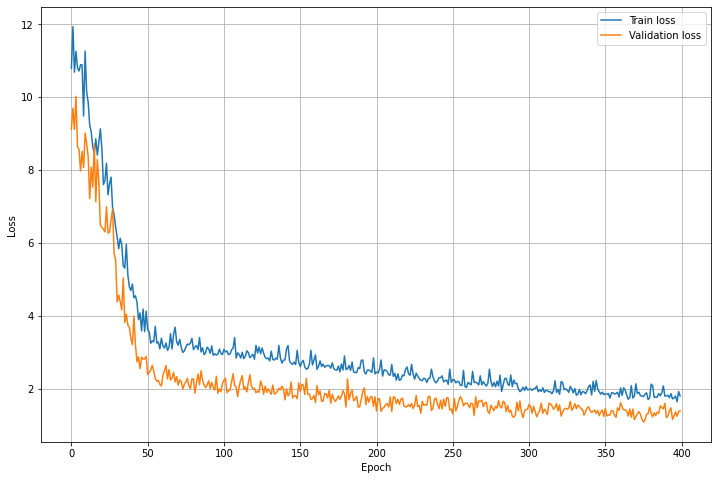

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
#plt.semilogy
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Prediction, inference on new data

In [ ]:
x_vec = torch.linspace(-5.5,5.5,1000).to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
best_net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = best_net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
#beta_true = [-1.45, 1.12, 2.3]
#true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


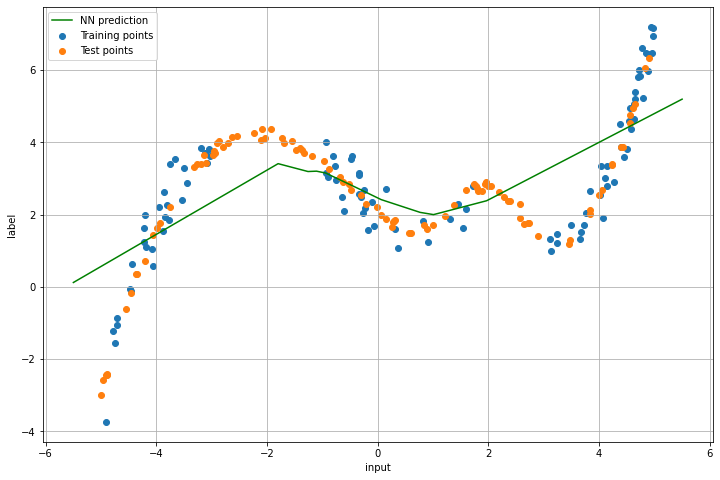

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.plot(x_vec, y_vec, label='NN prediction', color='green')
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()